# Sequências - Aula Prática
## RNNs (Recurrent Neural Networks)

Neste notebook iremos continuar nossos estudos de redes neurais recorrentes (RNNs), trabalhando dessa vez com modelos `seq2seq` (*sequence-to-sequence*) para construir um tradutor de francês para inglês, uma ideia simples mas poderosa onde duas RNNs trabalham em conjunto para transformar uma sequência em outra.

![](https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/seq2seq.png?raw=true)

- Esse notebook foi fortemente inspirado no terceiro tutorial da série [NLP From Scratch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html), disponibilizado no site do PyTorch.

- **Importante:** caso esteja rodando esse notebook no ambiente da Tatu, favor executar a seguinte célula. Caso contrário, basta ignorar a sua execução.

In [1]:
%load_ext nbproxy

Chave:  ewav
Senha: ········



Variáveis de ambiente http_proxy e https_proxy configuradas!



Variáveis de ambiente http_proxy e https_proxy configuradas!


Instalando pacotes necessários para realizarmos manipulações e outras operações com texto.

In [2]:
!pip install unidecode

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.6 MB/s eta 0:00:00 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


## Importação de pacotes

In [3]:
import re
import torch
import random

import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

from time import time
from tqdm.notebook import tqdm
from unidecode import unidecode

from torch.utils.data import Dataset, DataLoader

In [4]:
# Verificando se temos CUDA disponível e selecionando o device que será utilizado
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device escolhido:', device)

Device escolhido: cuda


## Entendimento da base de dados

A base de dados trabalhada durante esse notebook consiste em um arquivo `.txt` que possui pares de frases tanto em inglês quanto em francês, separados por um *tab*.

In [5]:
!head /pgeoprj/ciag2023/datasets/sequence_datasets/seq2seq/eng-fra.txt

Go.	Va !
Run!	Cours !
Run!	Courez !
Wow!	Ça alors !
Fire!	Au feu !
Help!	À l'aide !
Jump.	Saute.
Stop!	Ça suffit !
Stop!	Stop !
Stop!	Arrête-toi !


## Processamento da base de dados

De maneira similar à codificação feita em notebooks anteriores, iremos representar cada palavra de uma linguagem como sendo um índice numérico. Como iremos trabalhar com mais de uma linguagem, é natural criarmos uma classe, denominada de `Language`, para conter os dicionários que irão mapear palavras para índices (`word2idx`) e índices para palavras (`idx2word`).

Além disso, manteremos um terceiro dicionário chamado de `word_counter` para manter salvo a frequência de cada palavra nos dados daquela linguagem. Futuramente, iremos utilizar essa frequência para filtrar entradas que contém palavras raras, reduzindo assim a gigantesca base de dados para termos algo que executa de forma mais rápida, indiretamente facilitando o treinamento da nossa rede.

> Note que nesse notebook nós faremos o uso dos *tokens* especiais: **\<pad\>**, **\<sos\>** e **\<eos\>**, definindo de forma manual os índices relacionados com cada *token*.

In [6]:
PAD_INDEX = 0
SOS_INDEX = 1
EOS_INDEX = 2

class Language:
    def __init__(self, name):
        self.name = name
        self.idx_counter = 3

        self.word2idx = {}
        self.word_counter = {}
        self.idx2word = {PAD_INDEX: '<pad>', SOS_INDEX: '<sos>', EOS_INDEX: '<eos>'}

    def __len__(self):
        return self.idx_counter

    def add_sentence(self, sentence):
        for word in sentence.split(' '):
            self.add_word(word)

    def add_word(self, word):
        if word not in self.word2idx:
            self.word_counter[word] = 1
            self.word2idx[word] = self.idx_counter
            self.idx2word[self.idx_counter] = word
            self.idx_counter += 1
        else:
            self.word_counter[word] += 1

    def trim(self, threshold):
        keep_words = []

        for word, count in self.word_counter.items():
            if count >= threshold:
                keep_words.append(word)

        ratio = len(keep_words) / len(self.word2idx)
        print(f'Razão de palavras mantidos: {ratio:.4f}')

        # Reinicializando dicionários
        self.word2idx = {}
        self.word2count = {}
        self.idx2word = {PAD_INDEX: '<pad>', SOS_INDEX: '<sos>', EOS_INDEX: '<eos>'}
        self.idx_counter = 3

        for word in keep_words:
            self.add_word(word)

Os textos do arquivo estão todos em [Unicode](https://pt.wikipedia.org/wiki/Unicode). Para simplificar o dado, iremos converter todos os caracteres Unicode em [ASCII](https://pt.wikipedia.org/wiki/ASCII), tornando tudo em caixa baixa e removendo boa parte dos sinais diacríticos através da função `preprocess_string`.

> O módulo `re` é para aproveitarmos do poder de utilizar *expressões regulares*, ou do inglês *regular expressions*, permitindo realizar casamento e processamento de *strings* rapidamente.

In [7]:
def preprocess_string(string):
    ascii = unidecode(string).lower().strip()
    ascii = re.sub(r"([.!?])", r" \1", ascii)  # colocando um espaço entre texto e pontuação
    ascii = re.sub(r"[^a-zA-Z.!?]+", r" ", ascii)  # removendo tudo que não é um token válido
    ascii = ascii.strip()

    return ascii

# Exemplos de uso do preprocess_string
print(preprocess_string('kožušček'))
print(preprocess_string('François'))
print(preprocess_string("J'ai froid."))

kozuscek
francois
j ai froid .


Para ler os dados do arquivo `.txt`, nós iremos separar o conteúdo em linhas e depois cada linha em pares `(frase1, frase2)`. Como vimos anteriormente, as frases estão separadas por *tab* (`\t`), onde a primeira frase está em inglês e a segunda em francês. Já que queremos fazer uma tradução no sentido francês $\rightarrow$ inglês, iremos salvar os pares na ordem inversa, mantendo uma ideia de `(entrada, saída)`.

In [8]:
def build_pairs():
    with open('/pgeoprj/ciag2023/datasets/sequence_datasets/seq2seq/eng-fra.txt', 'r') as fp:
        lines = fp.readlines()

    pairs = []
    for line in lines:
        sentence1, sentence2 = line.split('\t')
        pairs.append((preprocess_string(sentence2), preprocess_string(sentence1)))

    return pairs

pairs = build_pairs()
print('Número de pares:', len(pairs))
print('Exemplo dos primeiros 3 pares:', pairs[:3])

Número de pares: 135842
Exemplo dos primeiros 3 pares: [('va !', 'go .'), ('cours !', 'run !'), ('courez !', 'run !')]


Como temos muitos exemplos de frases, e queremos treinar algo relativamente rápido, iremos reduzir o número de sentenças e usar apenas entradas relativamente simples e curtas, com no máximo 10 palavras (incluindo `<eos>`). Além disso, iremos trabalhar apenas com entradas que traduzem para algo do tipo "*I am*", "*He is*", etc. Tudo isso será condensado na função `filter_pair`.

In [9]:
MAX_LENGTH = 10

eng_prefixes = (
    'i am ', 'i m ',
    'he is', 'he s ',
    'she is', 'she s ',
    'you are', 'you re ',
    'we are', 'we re ',
    'they are', 'they re '
)

def filter_pair(pair):
    text1_length = len(pair[0].split(' '))
    text2_length = len(pair[1].split(' '))

    return text1_length < MAX_LENGTH and \
           text2_length < MAX_LENGTH and \
           pair[1].startswith(eng_prefixes)

pairs = list(filter(filter_pair, pairs))
print('Novo número de pares:', len(pairs))
print('Exemplo dos três primeiros novos pares:', pairs[:3])

Novo número de pares: 10601
Exemplo dos três primeiros novos pares: [('j ai ans .', 'i m .'), ('je vais bien .', 'i m ok .'), ('ca va .', 'i m ok .')]


Finalmente, iremos criar o escopo de cada linguagem que iremos trabalhar.

In [10]:
def build_languages(pairs):
    input_language = Language('fra')
    output_language = Language('eng')

    for sentence1, sentence2 in pairs:
        input_language.add_sentence(sentence1)
        output_language.add_sentence(sentence2)

    return input_language, output_language

input_language, output_language = build_languages(pairs)
print(f'Número de tokens da linguagem {input_language.name}: {len(input_language)}')
print(f'Número de tokens da linguagem {output_language.name}: {len(output_language)}')
print('Exemplo aleatório de um par:', random.choice(pairs))

Número de tokens da linguagem eng: 4350
Número de tokens da linguagem fra: 2805
Exemplo aleatório de um par: ('il est souvent absent de l ecole .', 'he is often absent from school .')


## Construção de um `Dataset` e `DataLoader`

Finalmente, iremos estudar uma forma de agrupar sequências de tamanhos diferentes em um único *batch* de dados, permitindo trabalhar com `batch_size` em modelos recorrentes.

Para isso, faremos um uso extensivo do módulo `torch.nn.utils.rnn`, ou `rnn_utils` como definimos nos imports no começo desse notebook. A partir desse módulo, conseguimos aplicar *padding* em um conjunto de sequências, uniformizando o tamanho das sequências. Além disso, PyTorch disponibiliza um tipo específico de dados chamado de `PackedSequence`, destinado exclusivamente para modelos recorrentes, onde podemos usar as funções `pack_padded_sequence` e `pad_packed_sequence`, para converter de tensores para `PackedSequences` e vice-versa.

> **Importante:** O uso de `PackedSequences` é interessante quando trabalhamos com dados de tamanho variável, uma vez que os modelos do PyTorch conseguem efetivamente "pular" *tokens* `<pad>`, poupando memória e computação! Porém, o seu uso é bastante confuso e mal documentado. Como alternativa, podemos criar uma máscara e mascarar a função de perda do nosso modelo, fazendo com que gradientes associados com `<pad>` não sejam usados durante a atualização dos pesos da rede.

Como estamos trabalhando com sequências de tamanho variável, precisamos "ensinar" para o PyTorch como que iremos "colar" todas essas sequências para formar um único *batch*. Isso pode ser feito através da definição de uma função chamada `collate_fn` (algo como função de combinação), onde nela podemos usar a função `pad_sequence` para conseguir construir um *batch* de dados sem problemas. Aqui, iremos construir um tensor que já tem o tamanho máximo, predefinido anteriormente no código, descartando a necessidade de termos uma `collate_fn`.

- Por ora não iremos nos preocupar com a separação entre conjuntos de treino, validação e teste. O objetivo desse notebook é de ensinar como trabalhamos em cenários `seq2seq`, além de como utilizar modelos mais complexos como GRUs e LSTMs.

1. Implemente as funções `sentence2tensor` e `tensor2sentence` no Dataset. **Dica:** Lembre-se que as sequências de entrada podem ter tamanhos diferentes.

In [11]:
class TranslationDataset(Dataset):
    def __init__(self):
        pairs = build_pairs()
        self.pairs = list(filter(filter_pair, pairs))
        self.input_language, self.output_language = build_languages(self.pairs)

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        input_sentence, output_sentence = self.pairs[idx]
        input_tensor = self.sentence2tensor(input_sentence, is_input=True)
        output_tensor = self.sentence2tensor(output_sentence, is_input=False)

        return input_tensor, output_tensor

    def sentence2tensor(self, sentence, is_input=True):
        tensor = torch.full((MAX_LENGTH,), PAD_INDEX, dtype=torch.long)
        language = self.input_language if is_input else self.output_language

        words = sentence.split(' ')
        for idx, word in enumerate(words):
            tensor[idx] = language.word2idx[word]

        tensor[len(words)] = EOS_INDEX
        return tensor

    def tensor2sentence(self, tensor, is_input=True):
        language = self.input_language if is_input else self.output_language
        return ' '.join(language.idx2word[idx.item()] for idx in tensor)

Exemplo de uma amostra do `TranslationDataset`.

In [12]:
dataset = TranslationDataset()
input_tensor, output_tensor = dataset[42]

print('Tensor de entrada:', input_tensor)
print('Tensor de saída  :', output_tensor)

print('\nFrase de entrada:', dataset.tensor2sentence(input_tensor, is_input=True))
print('Frase de saída  :', dataset.tensor2sentence(output_tensor, is_input=False))

Tensor de entrada: tensor([ 3, 15, 12, 51,  6,  2,  0,  0,  0,  0])
Tensor de saída  : tensor([ 3,  4, 34,  5,  2,  0,  0,  0,  0,  0])

Frase de entrada: j en suis certain . <eos> <pad> <pad> <pad> <pad>
Frase de saída  : i m sure . <eos> <pad> <pad> <pad> <pad> <pad>


Exemplo de uma amostra do nosso `DataLoader`.

In [13]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

input_tensor, output_tensor = next(iter(dataloader))
print('Tamanho da entrada e saída:', (input_tensor.shape, output_tensor.shape))

Tamanho da entrada e saída: (torch.Size([32, 10]), torch.Size([32, 10]))


In [14]:
first_input = input_tensor[0]
first_output = output_tensor[0]

print('Tensor de entrada:', first_input)
print('Tensor de saída  :', first_output)

print('\nFrase de entrada:', dataset.tensor2sentence(first_input, is_input=True))
print('Frase de saída  :', dataset.tensor2sentence(first_output, is_input=False))

Tensor de entrada: tensor([ 120, 2844,  249, 1512,    6,    2,    0,    0,    0,    0])
Tensor de saída  : tensor([  76,   16, 1826,  740,  295, 1112,    5,    2,    0,    0])

Frase de entrada: elle demande l impossible . <eos> <pad> <pad> <pad> <pad>
Frase de saída  : she s asking for the impossible . <eos> <pad> <pad>


## Modelo *seq2seq*

Uma rede *sequence to sequence*, *seq2seq*, ou rede *encoder-decoder*, é um modelo que é composto por 2 RNNs, denominadas de *encoder* e *decoder*. O papel do *encoder* é de ler a sequência de entrada e gerar um **contexto** da entrada (última camada de *hidden state*); enquanto que o *decoder* utilizará esse **contexto** para produzir uma sequência de saída. Esse tipo de modelagem permite com que modelos *seq2seq* produza uma sequência de tamanho diferente da sequência de entrada, sendo ideal para traduções por exemplo.

![](https://github.com/ThiagoPoppe/ciag2024/blob/main/imagens/seq2seq.png?raw=true)

Além disso, por produzir um vetor de **contexto**, o modelo consegue lidar com problemas relacionado à ordem das palavras em diferentes línguas. Considere por exemplo a sentença: *Je ne suis pas le chat noir*, traduzida para *I am not the black cat*. Perceba que boa parte das palavras da entrada possuem uma tradução 1:1 com as palavras da saída, mas em uma ordem um pouco diferente, como no caso de *chat noir* ser traduzido para *black cat*.

2. Implemente o modelo `Encoder`. 

In [15]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        """
        Implementação de um encoder para o modelo seq2seq.

        Argumentos
        ----------
            vocab_size (int): tamanho do nosso vocabulário.
            embed_size (int): dimensão do embedding que usaremos.
            hidden_size (int): dimensão do estado oculto das camadas recorrentes.
        """

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.gru(embedded)
        return hidden  # estamos apenas interessados no contexto produzido pelo encoder

> **Notas:** É muito comum observarmos uma camada de *dropout* depois da camada de *embedding* na rede *encoder*. Aqui, o *dropout* atua no sentido de desconsiderar alguns *tokens* da entrada da rede, aumentando a capacidade da rede de aprender a traduzir uma frase mesmo com *tokens* faltantes.

3. Implemente o modelo `Decoder`. 

In [16]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        """
        Implementação de um encoder para o modelo seq2seq.

        Argumentos
        ----------
            vocab_size (int): tamanho do nosso vocabulário.
            embed_size (int): dimensão do embedding que usaremos.
            hidden_size (int): dimensão do estado oculto das camadas recorrentes.
        """

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, batch_first=True)

        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, vocab_size),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, encoder_hidden, target_tensor=None):
        """
        Método de forward da rede.

        Argumentos
        ----------
            encoder_hidden (torch.Tensor): último estado oculto do encoder
            target_tensor (torch.Tensor): tensor da sentença alvo (usado para teacher forcing)
        """

        decoder_outputs = []
        decoder_hidden = encoder_hidden

        batch_size = encoder_hidden.shape[1]  # segundo a documentação, o batch size no H está na segunda dimensão!
        decoder_input = torch.full((batch_size, 1), SOS_INDEX, dtype=torch.long, device=device)

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                idx = decoder_output.argmax(dim=-1)
                decoder_input = idx.detach()  # precisamos dar um detach para evitar loops no grafo

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        return decoder_outputs  # estamos interessados apenas na saída da rede decoder

    def forward_step(self, x, hidden):
        """
        Função auxiliar para definir um passo do forward.
        """

        x = self.embedding(x)
        output, hidden = self.gru(x, hidden)

        output = self.classifier(output)
        return output, hidden

In [26]:
batch_size = 32
torch.full((batch_size, 1), SOS_INDEX, dtype=torch.long, device=device).shape

torch.Size([32, 1])

Verificando o comportamento da rede com um *batch* aleatório.

In [18]:
encoder = Encoder(len(input_language), embed_size=32, hidden_size=64).to(device)
decoder = Decoder(len(output_language), embed_size=32, hidden_size=64).to(device)

x, y = next(iter(dataloader))
x = x.to(device)
y = y.to(device)

context = encoder(x)
outputs = decoder(context, y)
predictions = outputs.argmax(dim=-1)

print('Frase original   :', dataset.tensor2sentence(x[0], is_input=True))
print('Tradução original:', dataset.tensor2sentence(y[0], is_input=False))
print('Tradução da rede :', dataset.tensor2sentence(predictions[0], is_input=False))

Frase original   : je m ennuie tellement en ce moment . <eos> <pad>
Tradução original: i m so bored right now . <eos> <pad> <pad>
Tradução da rede : airport stressed middle talk manipulative manipulative jam disappear disappear cane


In [21]:
x.shape, y.shape, context.shape, outputs.shape, predictions.shape

(torch.Size([32, 10]),
 torch.Size([32, 10]),
 torch.Size([1, 32, 64]),
 torch.Size([32, 10, 2805]),
 torch.Size([32, 10]))

In [23]:
outputs.transpose(1,2).shape, y.shape

(torch.Size([32, 2805, 10]), torch.Size([32, 10]))

## Treinamento do modelo

4. Implemente a função `train_epoch`.

In [20]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    total_loss = 0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        context = encoder(X)
        outputs = decoder(context, y)

        # Precisamos fazer uma transposição da saída para entregar para a função de perda
        loss = criterion(outputs.transpose(1, 2), y)
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    total_loss /= len(dataloader)
    return total_loss

In [21]:
batch_size = 32
num_epochs = 50

print_every = 5
save_loss_every = 5

dataset = TranslationDataset()
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

encoder = Encoder(len(dataset.input_language), embed_size=100, hidden_size=128).to(device)
decoder = Decoder(len(dataset.output_language), embed_size=100, hidden_size=128).to(device)

criterion = nn.NLLLoss(ignore_index=PAD_INDEX)  # iremos ignorar o gradiente vindo dos tokens <pad>
encoder_optimizer = optim.Adam(encoder.parameters(), lr=0.001)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=0.001)

losses = []
save_loss = 0
print_loss = 0

start_time = time()

for epoch in range(1, num_epochs + 1):
    loss = train_epoch(dataloader, encoder, decoder,
                       encoder_optimizer, decoder_optimizer, criterion)

    save_loss += loss
    print_loss += loss

    if epoch % print_every == 0:
        print_loss /= print_every
        elapsed_time = time() - start_time

        print(f'Epoch [{epoch}/{num_epochs}] => average loss: {print_loss:.5f}, ' \
              f'elapsed time: {elapsed_time:.2f} seconds')
        print_loss = 0

    if epoch % save_loss_every == 0:
        save_loss /= save_loss_every
        losses.append(save_loss)
        save_loss = 0

Epoch [5/50] => average loss: 2.20657, elapsed time: 18.98 seconds
Epoch [10/50] => average loss: 1.24865, elapsed time: 37.40 seconds
Epoch [15/50] => average loss: 0.83561, elapsed time: 55.80 seconds
Epoch [20/50] => average loss: 0.57175, elapsed time: 74.20 seconds
Epoch [25/50] => average loss: 0.38994, elapsed time: 92.62 seconds
Epoch [30/50] => average loss: 0.26486, elapsed time: 111.03 seconds
Epoch [35/50] => average loss: 0.18465, elapsed time: 129.46 seconds
Epoch [40/50] => average loss: 0.13246, elapsed time: 147.87 seconds
Epoch [45/50] => average loss: 0.10042, elapsed time: 166.28 seconds
Epoch [50/50] => average loss: 0.07901, elapsed time: 184.69 seconds


Plotando o gráfico da função de perda ao longo das épocas.

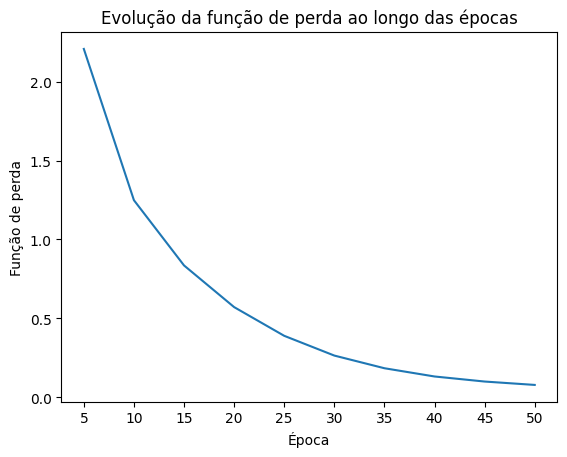

In [22]:
plt.title('Evolução da função de perda ao longo das épocas')
plt.xlabel('Época')
plt.ylabel('Função de perda')

plt.plot(losses)
plt.xticks(range(len(losses)), range(save_loss_every, num_epochs+1, save_loss_every))
plt.show()

## Avaliação qualitativa dos resultados

O método de *evaluation* da rede é similar ao treinamento. Porém, dessa vez nós não iremos aplicar *teacher forcing*, uma vez que não temos a palavra-alvo para o tempo $t$. Sendo assim, a predição do tempo $t$ será dada pela **previsão** da rede *decoder* no tempo $t-1$. Além disso, caso a rede preveja um *token* `<eos>`, iremos parar a geração antes de gerar uma sentença com o tamanho máximo.

In [23]:
def evaluate(sentence_tensor, encoder, decoder):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        sentence_tensor = sentence_tensor.to(device)
        context = encoder(sentence_tensor)

        predictions = []
        decoder_hidden = context
        decoder_input = torch.tensor([SOS_INDEX], dtype=torch.long, device=device)

        for i in range(MAX_LENGTH):
            output, decoder_hidden  = decoder.forward_step(decoder_input, decoder_hidden)

            prediction = output.argmax(dim=-1)
            predictions.append(prediction)

            if prediction.item() == EOS_INDEX:
                break

            decoder_input = prediction.detach()  # precisamos dar um detach para evitar loops no grafo

    return predictions

In [24]:
sentence, label = pairs[0]

sentence_tensor = dataset.sentence2tensor(sentence, is_input=True)
sentence_tensor = sentence_tensor.to(device)

predictions = evaluate(sentence_tensor, encoder, decoder)
print(f'> {sentence}')
print(f'= {label}')
print(f'< {dataset.tensor2sentence(predictions, is_input=False)}')

> j ai ans .
= i m .
< i am years old . <eos>


In [25]:
sentence, label = pairs[10]

sentence_tensor = dataset.sentence2tensor(sentence, is_input=True)
sentence_tensor = sentence_tensor.to(device)

predictions = evaluate(sentence_tensor, encoder, decoder)
print(f'> {sentence}')
print(f'= {label}')
print(f'< {dataset.tensor2sentence(predictions, is_input=False)}')

> je suis timide .
= i m shy .
< i m shy . <eos>


In [26]:
sentence, label = pairs[42]

sentence_tensor = dataset.sentence2tensor(sentence, is_input=True)
sentence_tensor = sentence_tensor.to(device)

predictions = evaluate(sentence_tensor, encoder, decoder)
print(f'> {sentence}')
print(f'= {label}')
print(f'< {dataset.tensor2sentence(predictions, is_input=False)}')

> j en suis certain .
= i m sure .
< i m sure . <eos>


In [27]:
sentence = 'je vais me baigner'

sentence_tensor = dataset.sentence2tensor(sentence, is_input=True)
sentence_tensor = sentence_tensor.to(device)

predictions = evaluate(sentence_tensor, encoder, decoder)
print(f'> {sentence}')
print(f'< {dataset.tensor2sentence(predictions, is_input=False)}')

> je vais me baigner
< i m going to get married . <eos>


In [28]:
sentence = 'tu as la confiance de tous'

sentence_tensor = dataset.sentence2tensor(sentence, is_input=True)
sentence_tensor = sentence_tensor.to(device)

predictions = evaluate(sentence_tensor, encoder, decoder)
print(f'> {sentence}')
print(f'< {dataset.tensor2sentence(predictions, is_input=False)}')

> tu as la confiance de tous
< you are trusted by every one . <eos>
